<a href="https://colab.research.google.com/github/Nermine-Ou/CodeAlpha_Titanic_Survival_Prediction/blob/main/TitanicSurvival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survival Prediction in Python - Machine Learning Project


##Importing Libraries and Initial setup


In [22]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')


In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape


(891, 12)

In [24]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


***Data Dictionary***

**Survived**	Survival

**pclass**	A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**sex**	Sex

**Age**	Age in years	(fractional if less than 1. If the age is estimated, is it in the form of xx.5)

**sibsp** 	# of siblings / spouses aboard the Titanic
(Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored))

**parch**	# of parents / children aboard the Titanic
(Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.)

**ticket**	Ticket number

**fare**	Passenger fare

**cabin**	Cabin number

**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [26]:
train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

##EDA

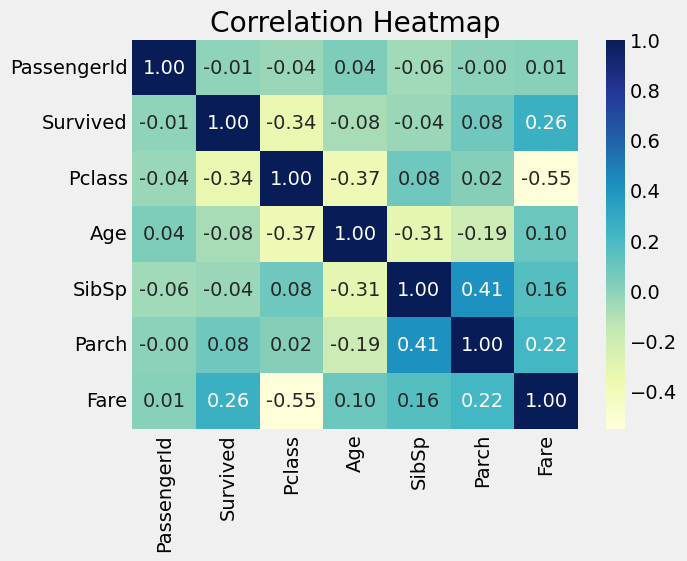

In [27]:
# Exclude non-numeric columns
numeric_titanic_data = train.select_dtypes(include=[np.number])

# Generate the correlation matrix
correlation_matrix = numeric_titanic_data.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Here we can see for example that the higher the nb of the pclass means
the higher the status, the higher the survival rate of the individual.


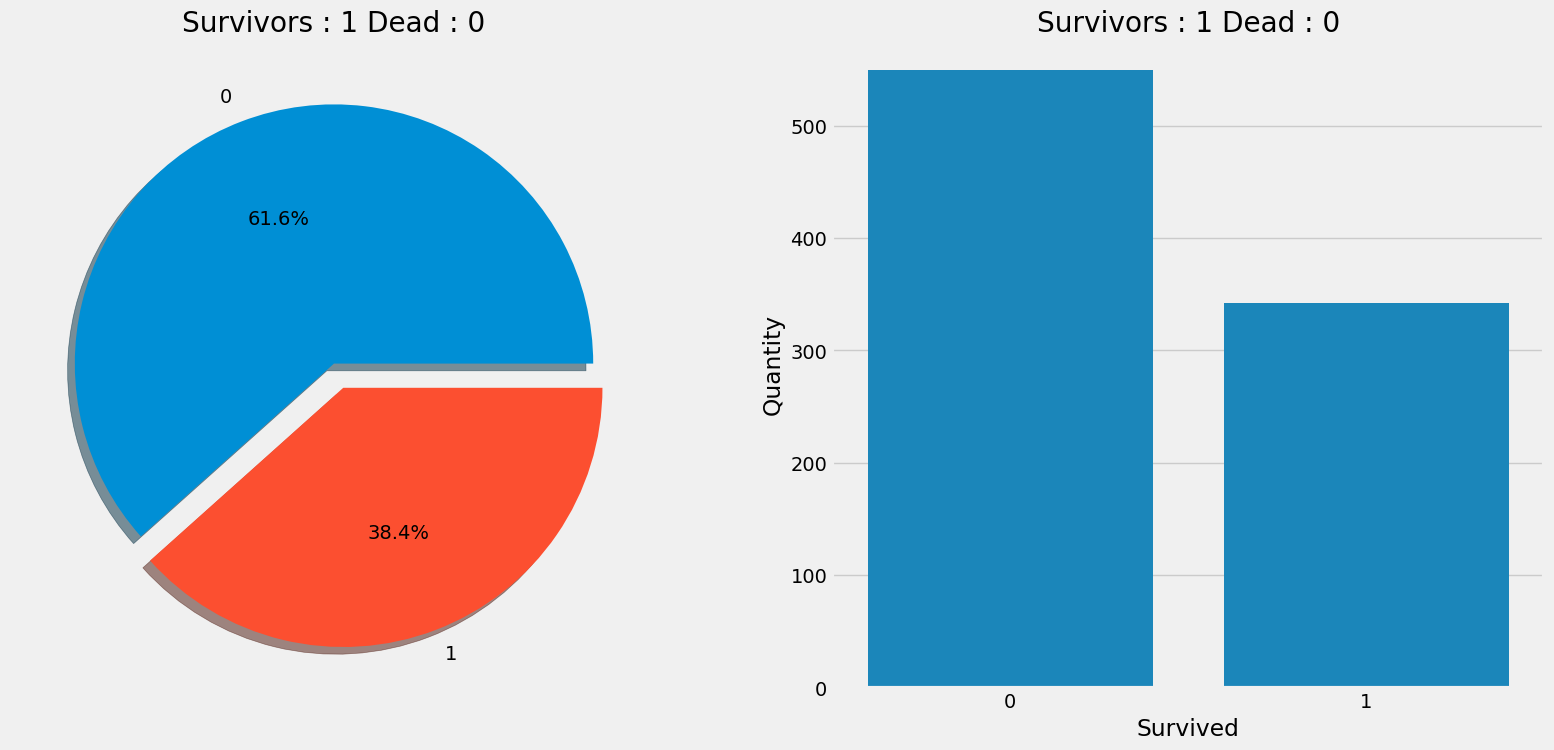

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survivors : 1 Dead : 0')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors : 1 Dead : 0')
plt.show()


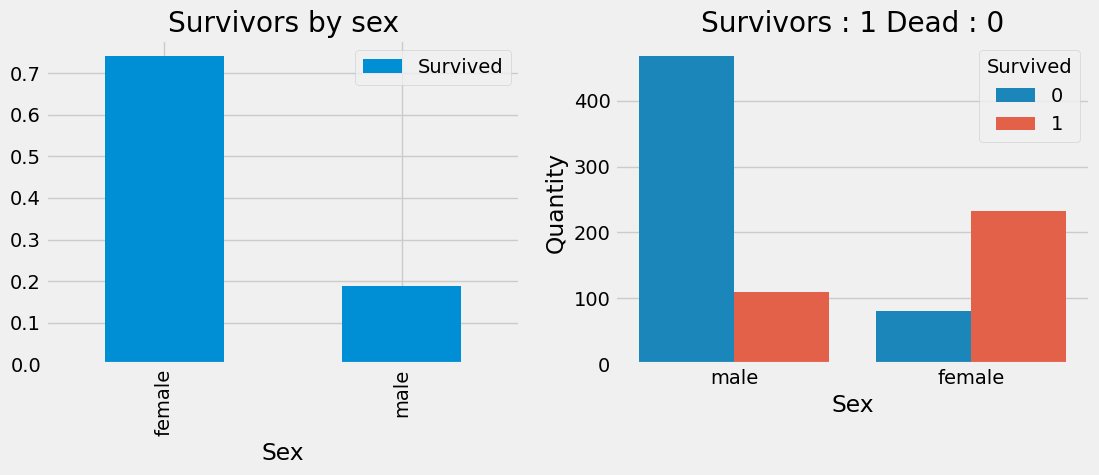

In [29]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survivors by sex')
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors : 1 Dead : 0')
plt.show()


##Feature Engineering

The main tasks in this step is to drop unnecessary features and to convert string data into the numerical category for easier training.

Since the Cabin feature is not important we will drop it, but a new column derived from Cabin column will be made to see if there was any cabin information allotted or not.

In [30]:
# Create a new column cabinbool indicating
# if the cabin value was given or was NaN
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

# Delete the column 'Cabin' from test
# and train dataset
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)


Same goes for the Ticket feature.

In [31]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)


There are missing values in the Embarked feature. For that, we will replace the NULL values with ‘S’ as the number of Embarks for ‘S’ are higher than the other two.



In [32]:
# replacing the missing values in
# the Embarked feature with S
train = train.fillna({"Embarked": "S"})


Sorting ages into groups to have fewer categories.

In [33]:
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager',
		'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)


In the ‘title’ column for both the test and train set, we will categorize them into an equal number of classes. Then we will assign numerical values to the title for convenience of model training.



In [34]:
# create a combined group of both datasets
combine = [train, test]

# extract a title for each Name in the
# train and test datasets
for dataset in combine:
	dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

# replace various titles with more common names
for dataset in combine:
	dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
												'Don', 'Dr', 'Major',
												'Rev', 'Jonkheer', 'Dona'],
												'Rare')

	dataset['Title'] = dataset['Title'].replace(
		['Countess', 'Lady', 'Sir'], 'Royal')
	dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
	dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
	dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
				"Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
	dataset['Title'] = dataset['Title'].map(title_mapping)
	dataset['Title'] = dataset['Title'].fillna(0)


Now filling missing age values

In [35]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() # Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() # Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() # Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() # Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() # Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
					3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
	if train["AgeGroup"][x] == "Unknown":
		train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
	if test["AgeGroup"][x] == "Unknown":
		test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]


In [36]:
# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
			'Student': 4, 'Young Adult': 5, 'Adult': 6,
			'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

# dropping the Age feature for now, might change
train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)


In [37]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)


In [38]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)


In [39]:
for x in range(len(test["Fare"])):
	if pd.isnull(test["Fare"][x]):
		pclass = test["Pclass"][x] # Pclass = 3
		test["Fare"][x] = round(
			train[train["Pclass"] == pclass]["Fare"].mean(), 4)

# map Fare values into groups of
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4,
							labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4,
						labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)


##Model Training

Random forest as the algorithm of choice to perform model training.

In [40]:
from sklearn.model_selection import train_test_split

# Drop the Survived and PassengerId
# column from the trainset
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(
	predictors, target, test_size=0.2, random_state=0)


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

# Fit the training data along with its output
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

# Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)


84.36


##Predection

In [42]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

# set the output as a dataframe and convert
# to csv file named resultfile.csv
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})
output.to_csv('resultfile.csv', index=False)
